In [1]:

from __future__ import absolute_import, division, print_function

import pprint
import argparse
import logging
import os
import random
import sys
import pickle
import copy
import collections
import math

import numpy as np
import numpy
import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler,TensorDataset

from torch.nn import CrossEntropyLoss, MSELoss

from transformer import BertForSequenceClassification,WEIGHTS_NAME, CONFIG_NAME
from transformer.modeling_quant import BertForSequenceClassification as QuantBertForSequenceClassification
from transformer import BertForQuestionAnswering,WEIGHTS_NAME, CONFIG_NAME
from transformer.modeling_quant import BertForQuestionAnswering as QuantBertForQuestionAnswering
from transformer import BertTokenizer
from transformer import BertAdam
from transformer import BertConfig
from transformer import QuantizeLinear, QuantizeAct, BertSelfAttention, FP_BertSelfAttention, ClipLinear
from utils_glue import *
from bertviz import model_view
import json
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch.nn.functional as F

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0 
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count



def get_tensor_data(output_mode, features):
    if output_mode == "classification":
        all_label_ids = torch.tensor([f.label_id for f in features], dtype=torch.long)
    elif output_mode == "regression":
        all_label_ids = torch.tensor([f.label_id for f in features], dtype=torch.float)


    all_seq_lengths = torch.tensor([f.seq_length for f in features], dtype=torch.long)
    all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
    all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
    tensor_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids,all_label_ids, all_seq_lengths)
    return tensor_data, all_label_ids


# Dataset

In [18]:
task_name = "squadv1.1" # squadv1.1 squadv2.0
# task_name = "squadv1.1" 
bert_size = "large"
max_seq_length = 384
doc_stride = 128
max_query_length = 64


In [19]:

if bert_size == "large":
    layer_num = 24
    head_num = 16
else: 
    layer_num = 12
    head_num = 12
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_dir = "models"
output_dir = "output"

if bert_size == "large":
    model_dir = os.path.join(model_dir, "BERT_large")
    output_dir = os.path.join(output_dir, "BERT_large")

    
def read_squad_examples(input_file, is_training, version_2_with_negative):
    """Read a SQuAD json file into a list of SquadExample."""
    with open(input_file, "r", encoding='utf-8') as reader:
        input_data = json.load(reader)["data"]

    def is_whitespace(c):
        if c == " " or c == "\t" or c == "\r" or c == "\n" or ord(c) == 0x202F:
            return True
        return False

    examples = []
    for entry in input_data:
        for paragraph in entry["paragraphs"]:
            paragraph_text = paragraph["context"]
            doc_tokens = []
            char_to_word_offset = []
            prev_is_whitespace = True
            for c in paragraph_text:
                if is_whitespace(c):
                    prev_is_whitespace = True
                else:
                    if prev_is_whitespace:
                        doc_tokens.append(c)
                    else:
                        doc_tokens[-1] += c
                    prev_is_whitespace = False
                char_to_word_offset.append(len(doc_tokens) - 1)

            for qa in paragraph["qas"]:

                qas_id = qa["id"]
                question_text = qa["question"]
                start_position = None
                end_position = None
                orig_answer_text = None
                is_impossible = False
                if is_training:
                    if version_2_with_negative:
                        if 'is_impossible' not in qa:
                            qa['is_impossible'] = True
                        is_impossible = qa["is_impossible"]
                    if (len(qa["answers"]) != 1) and (not is_impossible):
                        raise ValueError(
                            "For training, each question should have exactly 1 answer.")
                    if not is_impossible:
                        answer = qa["answers"][0]
                        orig_answer_text = answer["text"]
                        answer_offset = answer["answer_start"]
                        answer_length = len(orig_answer_text)
                        start_position = char_to_word_offset[answer_offset]
                        end_position = char_to_word_offset[answer_offset + answer_length - 1]
                        # Only add answers where the text can be exactly recovered from the
                        # document. If this CAN'T happen it's likely due to weird Unicode
                        # stuff so we will just skip the example.
                        #
                        # Note that this means for training mode, every example is NOT
                        # guaranteed to be preserved.
                        actual_text = " ".join(doc_tokens[start_position:(end_position + 1)])
                        cleaned_answer_text = " ".join(
                            whitespace_tokenize(orig_answer_text))
                        if actual_text.find(cleaned_answer_text) == -1:
                            logger.warning("Could not find answer: '%s' vs. '%s'",
                                           actual_text, cleaned_answer_text)
                            continue
                    else:
                        start_position = -1
                        end_position = -1
                        orig_answer_text = ""

                example = SquadExample(
                    qas_id=qas_id,
                    question_text=question_text,
                    doc_tokens=doc_tokens,
                    orig_answer_text=orig_answer_text,
                    start_position=start_position,
                    end_position=end_position,
                    is_impossible=is_impossible)
                examples.append(example)

    logger.info('load {} examples!'.format(len(examples)))
    return input_data,examples

class SquadExample(object):
    """
    A single training/test example for the Squad dataset.
    For examples without an answer, the start and end position are -1.
    """

    def __init__(self,
                 qas_id,
                 question_text,
                 doc_tokens,
                 orig_answer_text=None,
                 start_position=None,
                 end_position=None,
                 is_impossible=None):
        self.qas_id = qas_id
        self.question_text = question_text
        self.doc_tokens = doc_tokens
        self.orig_answer_text = orig_answer_text
        self.start_position = start_position
        self.end_position = end_position
        self.is_impossible = is_impossible

    def __str__(self):
        return self.__repr__()

    def __repr__(self):
        s = ""
        s += "qas_id: %s" % (self.qas_id)
        s += ", question_text: %s" % (
            self.question_text)
        s += ", doc_tokens: [%s]" % (" ".join(self.doc_tokens))
        if self.start_position:
            s += ", start_position: %d" % (self.start_position)
        if self.end_position:
            s += ", end_position: %d" % (self.end_position)
        if self.is_impossible:
            s += ", is_impossible: %r" % (self.is_impossible)
        return s


class InputFeatures(object):
    """A single set of features of data."""

    def __init__(self,
                 unique_id,
                 example_index,
                 doc_span_index,
                 tokens,
                 token_to_orig_map,
                 token_is_max_context,
                 input_ids,
                 input_mask,
                 segment_ids,
                 start_position=None,
                 end_position=None,
                 is_impossible=None):
        self.unique_id = unique_id
        self.example_index = example_index
        self.doc_span_index = doc_span_index
        self.tokens = tokens
        self.token_to_orig_map = token_to_orig_map
        self.token_is_max_context = token_is_max_context
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.start_position = start_position
        self.end_position = end_position
        self.is_impossible = is_impossible

def convert_examples_to_features(examples, tokenizer, max_seq_length,
                                 doc_stride, max_query_length, is_training):
    """Loads a data file into a list of `InputBatch`s."""

    unique_id = 1000000000

    features = []
    for (example_index, example) in enumerate(examples):
        query_tokens = tokenizer.tokenize(example.question_text)

        if len(query_tokens) > max_query_length:
            query_tokens = query_tokens[0:max_query_length]

        tok_to_orig_index = []
        orig_to_tok_index = []
        all_doc_tokens = []
        for (i, token) in enumerate(example.doc_tokens):
            orig_to_tok_index.append(len(all_doc_tokens))
            sub_tokens = tokenizer.tokenize(token)
            for sub_token in sub_tokens:
                tok_to_orig_index.append(i)
                all_doc_tokens.append(sub_token)

        tok_start_position = None
        tok_end_position = None
        if is_training and example.is_impossible:
            tok_start_position = -1
            tok_end_position = -1
        if is_training and not example.is_impossible:
            tok_start_position = orig_to_tok_index[example.start_position]
            if example.end_position < len(example.doc_tokens) - 1:
                tok_end_position = orig_to_tok_index[example.end_position + 1] - 1
            else:
                tok_end_position = len(all_doc_tokens) - 1
            (tok_start_position, tok_end_position) = _improve_answer_span(
                all_doc_tokens, tok_start_position, tok_end_position, tokenizer,
                example.orig_answer_text)

        # The -3 accounts for [CLS], [SEP] and [SEP]
        max_tokens_for_doc = max_seq_length - len(query_tokens) - 3

        # We can have documents that are longer than the maximum sequence length.
        # To deal with this we do a sliding window approach, where we take chunks
        # of the up to our max length with a stride of `doc_stride`.
        _DocSpan = collections.namedtuple(  # pylint: disable=invalid-name
            "DocSpan", ["start", "length"])
        doc_spans = []
        start_offset = 0
        while start_offset < len(all_doc_tokens):
            length = len(all_doc_tokens) - start_offset
            if length > max_tokens_for_doc:
                length = max_tokens_for_doc
            doc_spans.append(_DocSpan(start=start_offset, length=length))
            if start_offset + length == len(all_doc_tokens):
                break
            start_offset += min(length, doc_stride)

        for (doc_span_index, doc_span) in enumerate(doc_spans):
            tokens = []
            token_to_orig_map = {}
            token_is_max_context = {}
            segment_ids = []
            tokens.append("[CLS]")
            segment_ids.append(0)
            for token in query_tokens:
                tokens.append(token)
                segment_ids.append(0)
            tokens.append("[SEP]")
            segment_ids.append(0)

            for i in range(doc_span.length):
                split_token_index = doc_span.start + i
                token_to_orig_map[len(tokens)] = tok_to_orig_index[split_token_index]

                is_max_context = _check_is_max_context(doc_spans, doc_span_index,
                                                       split_token_index)
                token_is_max_context[len(tokens)] = is_max_context
                tokens.append(all_doc_tokens[split_token_index])
                segment_ids.append(1)
            tokens.append("[SEP]")
            segment_ids.append(1)

            input_ids = tokenizer.convert_tokens_to_ids(tokens)

            # The mask has 1 for real tokens and 0 for padding tokens. Only real
            # tokens are attended to.
            input_mask = [1] * len(input_ids)

            # Zero-pad up to the sequence length.
            while len(input_ids) < max_seq_length:
                input_ids.append(0)
                input_mask.append(0)
                segment_ids.append(0)

            assert len(input_ids) == max_seq_length
            assert len(input_mask) == max_seq_length
            assert len(segment_ids) == max_seq_length

            start_position = None
            end_position = None
            if is_training and not example.is_impossible:
                # For training, if our document chunk does not contain an annotation
                # we throw it out, since there is nothing to predict.
                doc_start = doc_span.start
                doc_end = doc_span.start + doc_span.length - 1
                out_of_span = False
                if not (tok_start_position >= doc_start and
                        tok_end_position <= doc_end):
                    out_of_span = True
                if out_of_span:
                    start_position = 0
                    end_position = 0
                else:
                    doc_offset = len(query_tokens) + 2
                    start_position = tok_start_position - doc_start + doc_offset
                    end_position = tok_end_position - doc_start + doc_offset
            if is_training and example.is_impossible:
                start_position = 0
                end_position = 0
            if example_index < 1:
                logger.info("*** Example ***")
                logger.info("unique_id: %s" % (unique_id))
                logger.info("example_index: %s" % (example_index))
                logger.info("doc_span_index: %s" % (doc_span_index))
                logger.info("tokens: %s" % " ".join(tokens))
                logger.info("token_to_orig_map: %s" % " ".join([
                    "%d:%d" % (x, y) for (x, y) in token_to_orig_map.items()]))
                logger.info("token_is_max_context: %s" % " ".join([
                    "%d:%s" % (x, y) for (x, y) in token_is_max_context.items()
                ]))
                logger.info("input_ids: %s" % " ".join([str(x) for x in input_ids]))
                logger.info(
                    "input_mask: %s" % " ".join([str(x) for x in input_mask]))
                logger.info(
                    "segment_ids: %s" % " ".join([str(x) for x in segment_ids]))
                if is_training and example.is_impossible:
                    logger.info("impossible example")
                if is_training and not example.is_impossible:
                    answer_text = " ".join(tokens[start_position:(end_position + 1)])
                    logger.info("start_position: %d" % (start_position))
                    logger.info("end_position: %d" % (end_position))
                    logger.info(
                        "answer: %s" % (answer_text))

            features.append(
                InputFeatures(
                    unique_id=unique_id,
                    example_index=example_index,
                    doc_span_index=doc_span_index,
                    tokens=tokens,
                    token_to_orig_map=token_to_orig_map,
                    token_is_max_context=token_is_max_context,
                    input_ids=input_ids,
                    input_mask=input_mask,
                    segment_ids=segment_ids,
                    start_position=start_position,
                    end_position=end_position,
                    is_impossible=example.is_impossible))
            unique_id += 1

    return features

def _check_is_max_context(doc_spans, cur_span_index, position):
    """Check if this is the 'max context' doc span for the token."""

    # Because of the sliding window approach taken to scoring documents, a single
    # token can appear in multiple documents. E.g.
    #  Doc: the man went to the store and bought a gallon of milk
    #  Span A: the man went to the
    #  Span B: to the store and bought
    #  Span C: and bought a gallon of
    #  ...
    #
    # Now the word 'bought' will have two scores from spans B and C. We only
    # want to consider the score with "maximum context", which we define as
    # the *minimum* of its left and right context (the *sum* of left and
    # right context will always be the same, of course).
    #
    # In the example the maximum context for 'bought' would be span C since
    # it has 1 left context and 3 right context, while span B has 4 left context
    # and 0 right context.
    best_score = None
    best_span_index = None
    for (span_index, doc_span) in enumerate(doc_spans):
        end = doc_span.start + doc_span.length - 1
        if position < doc_span.start:
            continue
        if position > end:
            continue
        num_left_context = position - doc_span.start
        num_right_context = end - position
        score = min(num_left_context, num_right_context) + 0.01 * doc_span.length
        if best_score is None or score > best_score:
            best_score = score
            best_span_index = span_index

    return cur_span_index == best_span_index


In [20]:
# Tokenizer Setting
data_dir = os.path.join("data",task_name)
teacher_model_dir = os.path.join(model_dir,task_name)
tokenizer = BertTokenizer.from_pretrained(teacher_model_dir, do_lower_case=True)

input_file = 'dev-v2.0.json' if task_name == "squadv2.0" else 'dev-v1.1.json'
version_2_with_negative = True if task_name == "squadv2.0" else False
_dev_file = os.path.join(data_dir,input_file)

data_dir = os.path.join("data",task_name)
processed_data_dir = os.path.join(data_dir,'processed')

# try:
dev_file = os.path.join(processed_data_dir, "dev.pkl")
eval_features = pickle.load(open(dev_file,'rb'))
dev_dataset, eval_examples = read_squad_examples(
    input_file=_dev_file, is_training=False,
    version_2_with_negative=version_2_with_negative)
# except:
#     dev_file = os.path.join(data_dir,input_file)
#     dev_dataset, eval_examples = read_squad_examples(
#                     input_file=dev_file, is_training=False,
#                     version_2_with_negative=version_2_with_negative)

eval_features = convert_examples_to_features(
    examples=eval_examples,
    tokenizer=tokenizer,
    max_seq_length=max_seq_length,
    doc_stride=doc_stride,
    max_query_length=max_query_length,
    is_training=False)

batch_size = 1
logger.info("  Num orig examples = %d", len(eval_examples))
logger.info("  Num split examples = %d", len(eval_features))
all_input_ids = torch.tensor([f.input_ids for f in eval_features], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in eval_features], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in eval_features], dtype=torch.long)
all_example_index = torch.arange(all_input_ids.size(0), dtype=torch.long)
eval_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_example_index)
eval_sampler = SequentialSampler(eval_data)
eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=batch_size)

06/15 03:10:06 AM load 10570 examples!
06/15 03:10:06 AM *** Example ***
06/15 03:10:06 AM unique_id: 1000000000
06/15 03:10:06 AM example_index: 0
06/15 03:10:06 AM doc_span_index: 0
06/15 03:10:06 AM tokens: [CLS] which nfl team represented the afc at super bowl 50 ? [SEP] super bowl 50 was an american football game to determine the champion of the national football league ( nfl ) for the 2015 season . the american football conference ( afc ) champion denver broncos defeated the national football conference ( nfc ) champion carolina panthers 24 – 10 to earn their third super bowl title . the game was played on february 7 , 2016 , at levi ' s stadium in the san francisco bay area at santa clara , california . as this was the 50th super bowl , the league emphasized the " golden anniversary " with various gold - themed initiatives , as well as temporarily suspend ##ing the tradition of naming each super bowl game with roman nu ##meral ##s ( under which the game would have been known as 

In [21]:
# Sampling Sentence 
i = 0 
# num = 3
num = 1234

for step, batch in enumerate(eval_dataloader):
    # model.train()
            
    batch = tuple(t.to(device) for t in batch)
    input_ids, input_mask, segment_ids, label_ids = batch
    i = i + 1
    if i == num:
        break
        
seq_length = input_mask[0].sum()
input_ids_sliced = input_ids[:,:seq_length]
input_id = []
for i in input_ids_sliced[0]:
    input_id.append(i.item())
tokens = tokenizer.convert_ids_to_tokens(input_id)

sample_sentence_a = str()
sample_sentence_b = str()
index = 0

for i, word in enumerate(tokens[1:-1]):
    if word == "[SEP]":
        break
    sample_sentence_a += word
    sample_sentence_a += " "
index = i

for i, word in enumerate(tokens[index+2:-1]):
    if word == "[SEP]":
        break
    sample_sentence_b += word
    sample_sentence_b += " "

sep_index = torch.where(input_ids[0] == 102)[0]

punc_index_1 = torch.where(input_ids[0] == 1010)[0] # comma
punc_index_2 = torch.where(input_ids[0] == 1012)[0] # period
punc_index = torch.cat([punc_index_1, punc_index_2])

if len(sample_sentence_b) > 1:
    sample_sentence_b_start = segment_ids[0].tolist().index(1)
else:
    sample_sentence_b_start = None

print(f"input_ids : {input_ids_sliced}")
print(f"tokens : {tokens}")
print(f"A : {sample_sentence_a}")
print(f"B : {sample_sentence_b}")
print(sep_index)
print("PUNC")
print(punc_index_1)
print(punc_index_2)

for i, token in enumerate(tokens):
    tokens[i] = token # + "_" + str(i)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10833/10833 [00:20<00:00, 530.22it/s]

comma -> 7.946459891073571
period -> 5.691959752607772


# Model Build

In [20]:
seed=42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
mse_func = MSELoss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_dir = "models"
output_dir = "output"

if bert_size == "large":
    model_dir = os.path.join(model_dir, "BERT_large")
    output_dir = os.path.join(output_dir, "BERT_large")

In [22]:
name_1 = "1SB_O"
name_2 = "1SB_M"

model_list = [name_1, name_2]
model_num = 0
mag_dict = dict()

# Teacher Model Build
teacher_model_dir = os.path.join(model_dir,task_name)
teacher_model = BertForQuestionAnswering.from_pretrained(teacher_model_dir)
teacher_model.to(device)
teacher_model.eval()
print()

# Student Model Build and Logging
for st_model_name in model_list:
    student_model_dir = os.path.join(output_dir, task_name, "exploration", st_model_name)   
    student_config = BertConfig.from_pretrained(student_model_dir)             
    student_model = QuantBertForQuestionAnswering.from_pretrained(student_model_dir, config = student_config)
    student_model.to(device)
    student_model.eval()
    model = student_model
    
    for name, module in student_model.named_modules():
        if isinstance(module, (QuantizeLinear, QuantizeAct, ClipLinear)):    
            module.act_flag = True
            module.weight_flag = True

    for l in range(layer_num):        
        mag_dict[f"{model_num}_min_{l}"] = []; mag_dict[f"{model_num}_max_{l}"] = []; mag_dict[f"{model_num}_std_{l}"] = []; mag_dict[f"{model_num}_mean_{l}"] = []
        if model_num == 0:
            mag_dict[f"tc_min_{l}"] = []; mag_dict[f"tc_max_{l}"] = []; mag_dict[f"tc_std_{l}"] = []; mag_dict[f"tc_mean_{l}"] = []

    teacher_logits, teacher_atts, teacher_reps, teacher_probs, teacher_zip = teacher_model(input_ids_sliced.to(device))
    student_logits, student_atts, student_reps, student_probs, student_zip  = model(input_ids_sliced.to(device), teacher_outputs=(teacher_probs, teacher_zip, teacher_reps, teacher_logits, teacher_atts))
    for l in range(layer_num):
        tc_attn_context, tc_attn_output, tc_value_vector, tc_sa_output = teacher_zip[l]
        st_attn_context, st_attn_output, st_value_vector, st_sa_output = student_zip[l]        
        st_ffn_output = student_reps[1+1]
        tc_ffn_output = teacher_reps[l+1]

        tc_output = tc_ffn_output
        st_output = st_ffn_output

        for token in range(len(tokens)):
            if model_num == 0:
                mag_dict[f"tc_min_{l}"].append(tc_output[0,token,:].min().item())
                mag_dict[f"tc_max_{l}"].append(tc_output[0,token,:].max().item())
                mag_dict[f"tc_mean_{l}"].append(tc_output[0,token,:].mean().item())
                mag_dict[f"tc_std_{l}"].append(tc_output[0,token,:].std().item())

            mag_dict[f"{model_num}_min_{l}"].append(st_output[0,token,:].min().item())
            mag_dict[f"{model_num}_max_{l}"].append(st_output[0,token,:].max().item())
            mag_dict[f"{model_num}_mean_{l}"].append(st_output[0,token,:].mean().item())
            mag_dict[f"{model_num}_std_{l}"].append(st_output[0,token,:].std().item())


    model_num += 1

06/15 03:21:46 AM Loading model models/BERT_large/squadv1.1/pytorch_model.bin
06/15 03:21:47 AM loading model...
06/15 03:21:47 AM done!

06/15 03:21:47 AM loading configuration file output/BERT_large/squadv1.1/exploration/1SB_O/config.json
06/15 03:21:52 AM Loading model output/BERT_large/squadv1.1/exploration/1SB_O/pytorch_model.bin
06/15 03:21:54 AM loading model...
06/15 03:21:54 AM done!


ValueError: too many values to unpack (expected 4)

In [28]:
input_ids[0][99]

tensor(1049, device='cuda:0')

In [30]:

for l in range(layer_num):
    token_avg_tc = teacher_probs[l][0,2,:,:].mean(dim=0)
    print(torch.sort(token_avg_tc, descending=True)[1][:20].cpu())


tensor([197,  15,  58,   7,  60,  66,  34,   0,  77,   8,  10,  55, 168,  97,
        137, 195,  69,  82, 112, 191])
tensor([  0,  30,  12, 132, 100,   2,  56, 146,  17,  31,  13,  42,  14,  61,
          1,  78,  80,  20, 123, 127])
tensor([  0, 164, 169, 141,  43, 132,  15, 135, 113, 194,  63,  84,  88, 149,
        104,  95,  90,  33, 156, 166])
tensor([  0, 165, 164,  63,  15, 136,  49, 114, 113,  14,  64,  50, 171,  16,
          3, 135,   2,  80,  31, 172])
tensor([  0,  63, 113, 164, 197,  15, 128,  73, 196,   3,  16, 124,  48,  14,
         94,  29, 172, 183,  81,  64])
tensor([  0,  15,   4,   3, 130,  48,  64, 152,   2,  11,   1,  16,  50,  55,
        124, 172, 139, 164, 185, 169])
tensor([  0, 197,  15, 164,  63, 113, 128, 155,  24, 148, 183,   3, 124, 160,
         32,  37, 196,  14, 151,  16])
tensor([  0, 197,  15, 118,  19,  89, 134,  36,  46, 124,  68,  48,   7, 174,
         72,  92, 110, 139, 170, 179])
tensor([  0, 197,  15,  63, 196, 113,  31,  80, 164, 183,  47,  

In [38]:
model_num = 0
for l in range(layer_num):
#     if l < 15:
#         continue
    fig, ax = plt.subplots(1, 1, figsize=(30, 5), dpi=100)
    ax.plot(list(range(len(tokens))), mag_dict[f"tc_min_{l}"], label="FP_min", color="gray", linewidth=2.5, linestyle="--")
    ax.plot(list(range(len(tokens))), mag_dict[f"tc_max_{l}"], label="FP_max", color="gray", linewidth=2.5, linestyle="-.")
    # ax.plot(tokens, mag_dict[f"tc_mean_{l}"], label="tc_mean", color="r")

    ax.plot(list(range(len(tokens))), mag_dict[f"0_min_{l}"], label="1SB_O", color="dodgerblue", linewidth=2.5)
    ax.plot(list(range(len(tokens))), mag_dict[f"0_max_{l}"], label="1SB_O", color="dodgerblue", linewidth=2.5)
    
    ax.plot(list(range(len(tokens))), mag_dict[f"1_min_{l}"], label="1SB_M", color="orange", linewidth=2.5)
    ax.plot(list(range(len(tokens))), mag_dict[f"1_max_{l}"], label="1SB_M", color="orange", linewidth=2.5)
    
    # ax.plot(tokens, mag_dict[f"2_min_{l}"], label="1SB_LSM_M", color="b", linestyle="-.")
    # ax.plot(tokens, mag_dict[f"2_max_{l}"], label="1SB_LSM_M", color="b", linestyle="-.")
    # ax.plot(tokens, mag_dict[f"{model_num}_mean_{l}"], label="st_mean", color="dodgerblue")
    ax.set_title(f"Attention Output Layer {l}", fontsize=20)
    ax.legend(loc=2, fontsize=15)
    plt.xticks(range(len(tokens)),rotation=45, fontsize=8)
    # ax.set_xlabel("Token Number", fontsize=20)
    plt.show()

In [47]:
len(tokens)

214

In [43]:
token_avg_tc = teacher_probs[1][0,1,:,:].mean(dim=0)
torch.sort(token_avg_tc, descending=True)[0][:5].sum()

tensor(0.9044, device='cuda:0', grad_fn=<SumBackward0>)

In [23]:
outlier_index = [173, 212] # [12, 42, 48, 56, 115, 126]
cls_index = 0

teacher_list = dict()
student_list = dict()

teacher_list["cls"] = []
student_list["cls"] = []

for i, outlier in enumerate(outlier_index):
    teacher_list[f"ol_{i}"] = []
    student_list[f"ol_{i}"] = []

for i, punc in enumerate(punc_index):
    teacher_list[f"punc_{i}"] = []
    student_list[f"punc_{i}"] = []

for i , sep in enumerate(sep_index):
    teacher_list[f"sep_{i}"] = []
    student_list[f"sep_{i}"] = []

# Order
seq_length = len(tokens) - 1

for l in range(layer_num):
    for h in range(head_num):
        token_avg_tc = teacher_probs[l][0,h,:,:].mean(dim=0)
        token_order_tc = torch.sort(token_avg_tc)[1]
        
        ratio = torch.where(token_order_tc == cls_index)[0] / seq_length
        teacher_list[f"cls"].append(ratio.item())
        
        for i, ol in enumerate(outlier_index):
            ratio = torch.where(token_order_tc == ol)[0] / seq_length
            teacher_list[f"ol_{i}"].append(ratio.item())
        
        for i, sep in enumerate(sep_index):
            ratio = torch.where(token_order_tc == sep)[0] / seq_length
            teacher_list[f"sep_{i}"].append(ratio.item())
        
        for i, punc in enumerate(punc_index):
            ratio = torch.where(token_order_tc == punc)[0] / seq_length
            teacher_list[f"punc_{i}"].append(ratio.item())

for l in range(layer_num):
    for h in range(head_num):
        token_avg_st = student_probs[l][0,h,:,:].mean(dim=0)
        token_order_st = torch.sort(token_avg_st)[1]
        
        ratio = torch.where(token_order_st == cls_index)[0] / seq_length
        student_list[f"cls"].append(ratio.item())
        
        for i, ol in enumerate(outlier_index):
            ratio = torch.where(token_order_st == ol)[0] / seq_length
            student_list[f"ol_{i}"].append(ratio.item())
        
        for i, sep in enumerate(sep_index):
            ratio = torch.where(token_order_st == sep)[0] / seq_length
            student_list[f"sep_{i}"].append(ratio.item())
        
        for i, punc in enumerate(punc_index):
            ratio = torch.where(token_order_st == punc)[0] / seq_length
            student_list[f"punc_{i}"].append(ratio.item())            

        

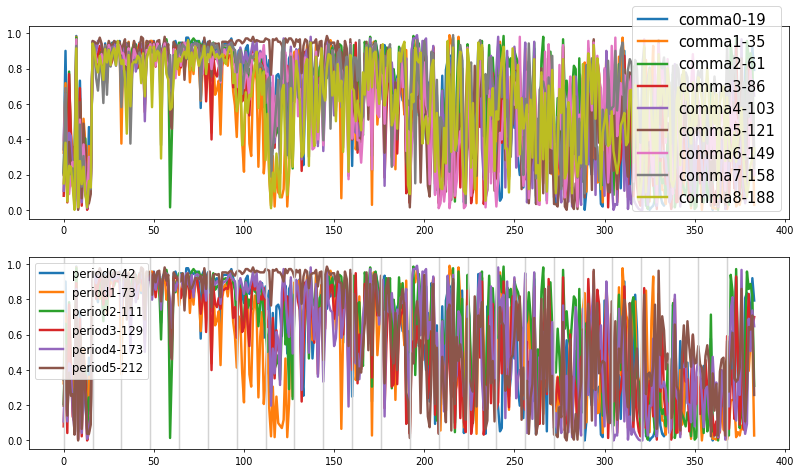

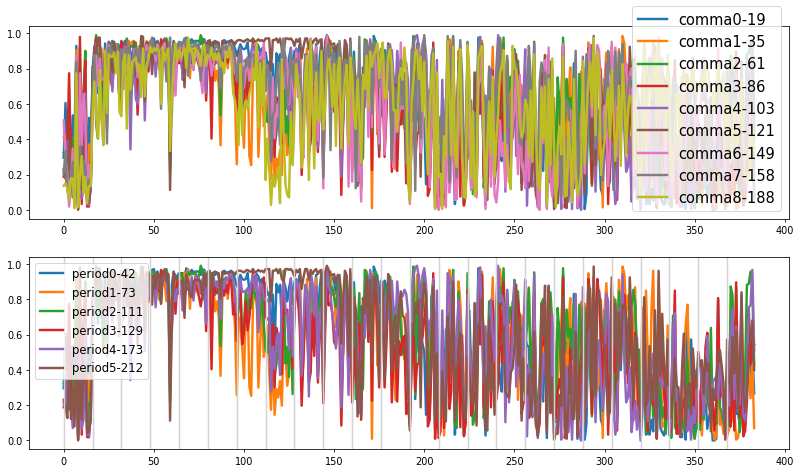

In [30]:
for dict_list in [teacher_list, student_list]:
    fig, [ax1,ax2] = plt.subplots(2, 1, figsize=(14, 8), dpi=70)
    # fig, ax1 = plt.subplots(1, 1, figsize=(14, 5), dpi=70)
    color_list = ["b", "c", "tab:blue", "tab:orange", "crimson", "red"]
    punc_name = ["comma", "comma", "comma", "period", "period"]
    # ax.plot(list(range(layer_num*head_num)), dict_list["sep_0"], label="sep_0", color='gray')
    # ax.plot(list(range(layer_num*head_num)), dict_list["sep_1"], label="sep_1", color='gray')
    # ax.plot(list(range(layer_num*head_num)), dict_list["cls"], label="cls", color='tab:brown')
    
#     for i, ol in enumerate(outlier_index):
#         ax1.plot(list(range(layer_num*head_num)), dict_list[f"ol_{i}"], label=f"index-{ol}-{tokens[ol]}", linewidth=2.5)
    for i, punc in enumerate(punc_index_1):
        ax1.plot(list(range(layer_num*head_num)), dict_list[f"punc_{i}"], label=f"comma{i}-{punc}", linewidth=2.5)

    for i, punc in enumerate(punc_index_2):
        ax2.plot(list(range(layer_num*head_num)), dict_list[f"punc_{i}"], label=f"period{i}-{punc}", linewidth=2.5)

    for l in range(layer_num):
        plt.axvline(x=l*16, color="lightgray")

    ax1.legend(fontsize=15, loc=4)
    ax2.legend(fontsize=12, loc=2)
    # ax1.set_xlim([280,384])
    # ax2.set_xlim([338,384])

In [20]:
mag_dict = dict()
for l in range(layer_num):        
    mag_dict[f"attn_min_{l}"] = []; mag_dict[f"attn_max_{l}"] = []; 
    mag_dict[f"ffn_min_{l}"] = []; mag_dict[f"ffn_max_{l}"] = []; 
    mag_dict[f"sa_min_{l}"] = []; mag_dict[f"sa_max_{l}"] = []; 
    mag_dict[f"sa_ffn_min_{l}"] = []; mag_dict[f"sa_ffn_max_{l}"] = []; 

for l in range(layer_num):
        tc_attn_context, tc_attn_output, tc_value_vector, tc_sa_output = teacher_zip[l]
        # st_attn_context, st_attn_output, st_value_vector, st_sa_output = student_zip[l]        
        # st_ffn_output = student_zip[2][1+1]
        tc_ffn_output = teacher_reps[l]
        
        tc_output = tc_attn_output
        # st_output = st_attn_output
        
        for token in range(len(tokens)):
          
            mag_dict[f"attn_min_{l}"].append(tc_attn_output[0,token,:].min().item())
            mag_dict[f"attn_max_{l}"].append(tc_attn_output[0,token,:].max().item())
            
            mag_dict[f"ffn_min_{l}"].append(tc_ffn_output[0,token,:].min().item())
            mag_dict[f"ffn_max_{l}"].append(tc_ffn_output[0,token,:].max().item())
            
            mag_dict[f"sa_min_{l}"].append(tc_sa_output[0,token,:].min().item())
            mag_dict[f"sa_max_{l}"].append(tc_sa_output[0,token,:].max().item())
            
            mag_dict[f"sa_ffn_min_{l}"].append((tc_ffn_output+tc_sa_output)[0,token,:].min().item())
            mag_dict[f"sa_ffn_max_{l}"].append((tc_ffn_output+tc_sa_output)[0,token,:].max().item())
               

In [ ]:
import copy
f2_dict = copy.deepcopy(mag_dict)

In [ ]:
for i, token in enumerate(tokens):
    tokens[i] = token + "_" + str(i)

In [ ]:
token_len=214
for l in range(layer_num):
    fig, [ax1,ax2,ax3,ax4] = plt.subplots(4, 1, figsize=(15, 10), dpi=70)
    ax1.plot(list(range(token_len)), mag_dict[f"ffn_min_{l}"], label="v2_ffn_min", color="tab:red", linewidth=2.5)
    ax1.plot(list(range(token_len)), mag_dict[f"ffn_max_{l}"], label="v2_ffn_max", color="tab:red", linewidth=2.5)
    
    ax2.plot(list(range(token_len)), mag_dict[f"sa_min_{l}"], label="v2_sa_min", color="orangered", linewidth=2.5)
    ax2.plot(list(range(token_len)), mag_dict[f"sa_max_{l}"], label="v2_sa_max", color="orangered", linewidth=2.5)
    
    ax3.plot(list(range(token_len)), mag_dict[f"sa_ffn_min_{l}"], label="v2_sa+ffn_min", color="c", linewidth=2.5)
    ax3.plot(list(range(token_len)), mag_dict[f"sa_ffn_max_{l}"], label="v2_sa+ffn_max", color="c", linewidth=2.5)
    
    ax4.plot(list(range(token_len)), mag_dict[f"attn_min_{l}"], label="v2_attn_min", color="dodgerblue", linewidth=2.5)
    ax4.plot(list(range(token_len)), mag_dict[f"attn_max_{l}"], label="v2_attn_max", color="dodgerblue", linewidth=2.5)
    
    
    ax1.set_title(f"Layer {l}", fontsize=15)
    ax1.legend(loc=2, fontsize=15)
    ax2.legend(loc=2, fontsize=15)
    ax3.legend(loc=2, fontsize=15)
    ax4.legend(loc=2, fontsize=15)
    
    plt.xticks(rotation=60, fontsize=10)
    
#     ax2.plot(list(range(152)), mag_dict[f"tc_min_{l}"], label="v1_FP_min", color="tab:blue", linewidth=2.5)
#     ax2.plot(list(range(152)), mag_dict[f"tc_max_{l}"], label="v1_FP_max", color="tab:blue", linewidth=2.5)
#     ax2.legend(loc=2, fontsize=15)
#     ax2.set_xlabel("Token Number", fontsize=3)

    plt.show()




In [ ]:
# for l in range(layer_num):
#     layer_sum = 0
#     print(f"layer{l}")
#     for h in range(head_num):
#         token_avg_tc = teacher_probs[l][0,h,:,:].mean(dim=0)
#         top_k_sum = torch.sort(token_avg_tc, descending=True)[0][:50].sum()
#         print(top_k_sum.item())
#         layer_sum += top_k_sum
#     print(f"mean -> {layer_sum / head_num}")
#     print()
        
        